# Course Project — UCI Credit Default (Simple)

This notebook follows the **course project guidelines** (Parts A–E) using the dataset `UCI_Credit_Card.csv`. It includes:
- Data understanding + basic stats + plots (Part A)
- PCA from scratch + sklearn comparison (Part B)
- Linear Regression with Gradient Descent from scratch (Part C)
- Logistic Regression from scratch (extra, helps for classification)
- Statistical evaluation: metrics, t-test vs baseline, bootstrap CI (Part E)

> Note: The original guideline also asks for **Perceptron + MLP**.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SKPCA
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

df = pd.read_csv("UCI_Credit_Card.csv")
df.shape, df.columns


((30000, 25),
 Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
        'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
        'default.payment.next.month'],
       dtype='object'))

Data Understanding & Preprocessing
- Describe dataset
- Handle missing/outliers
- Normalize features
- Compute mean/variance/covariance/correlation
- 2–3 plots + short notes

In [ ]:
display(df.head())
print("Shape:", df.shape)
print(df["default.payment.next.month"].value_counts(normalize=True).rename("class_ratio"))


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Shape: (30000, 25)
default.payment.next.month
0    0.7788
1    0.2212
Name: class_ratio, dtype: float64


Clean obvious category issues

In [ ]:
df_clean = df.copy()

df_clean["EDUCATION"] = df_clean["EDUCATION"].replace({0:4, 5:4, 6:4})

df_clean["MARRIAGE"] = df_clean["MARRIAGE"].replace({0:3})

print("Missing values per column (top 10):")
print(df_clean.isna().sum().sort_values(ascending=False).head(10))


Missing values per column (top 10):
ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
dtype: int64


Handle outliers (winsorization)

In [20]:
def winsorize_df(dataframe, cols, lower_q=0.01, upper_q=0.99):
    dfw = dataframe.copy()
    for c in cols:
        lo, hi = dfw[c].quantile(lower_q), dfw[c].quantile(upper_q)
        dfw[c] = dfw[c].clip(lo, hi)
    return dfw

numeric_cols = [c for c in df_clean.columns if c not in ["ID"]]
df_w = winsorize_df(df_clean, numeric_cols, 0.01, 0.99)


Basic statistics: mean, variance, covariance, correlation

In [ ]:
target_col = "default.payment.next.month"
feature_cols = [c for c in df_w.columns if c not in ["ID", target_col]]

X_all = df_w[feature_cols].values.astype(float)

mean_vec = X_all.mean(axis=0)
var_vec  = X_all.var(axis=0, ddof=1)  

cov_mat = np.cov(X_all, rowvar=False) 
corr_mat = np.corrcoef(X_all, rowvar=False) 

print("Mean vector shape:", mean_vec.shape)
print("Cov matrix shape:", cov_mat.shape)
print("Corr matrix shape:", corr_mat.shape)


Mean vector shape: (23,)
Cov matrix shape: (23, 23)
Corr matrix shape: (23, 23)


Visualizations
- Histogram of target (class balance)
- Histogram of LIMIT_BAL
- Scatter: AGE vs LIMIT_BAL

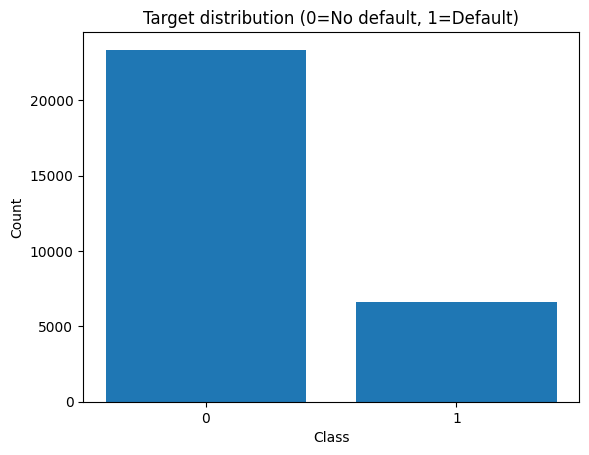

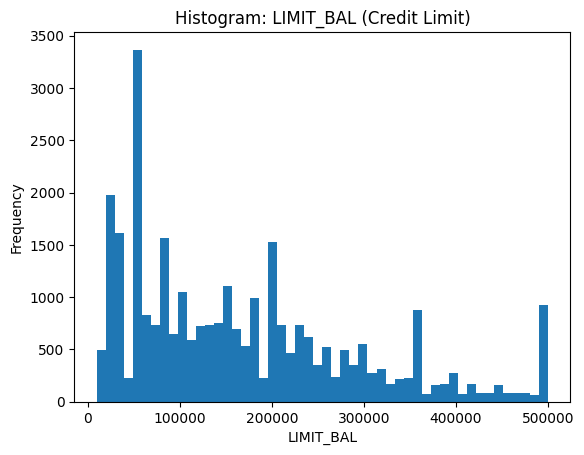

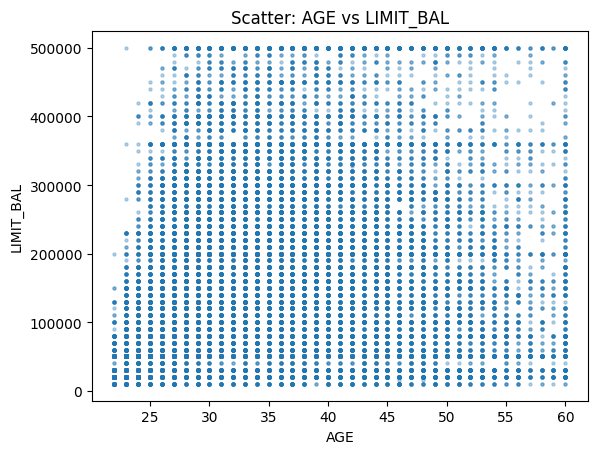

In [ ]:
counts = df_w[target_col].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target distribution (0=No default, 1=Default)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(df_w["LIMIT_BAL"].values, bins=50)
plt.title("Histogram: LIMIT_BAL (Credit Limit)")
plt.xlabel("LIMIT_BAL")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.scatter(df_w["AGE"].values, df_w["LIMIT_BAL"].values, s=5, alpha=0.3)
plt.title("Scatter: AGE vs LIMIT_BAL")
plt.xlabel("AGE")
plt.ylabel("LIMIT_BAL")
plt.show()


PCA from Scratch (15%)
- Implement PCA using eigen decomposition
- Scree plot
- Project to 2D and scatter plot
- Compare with sklearn PCA

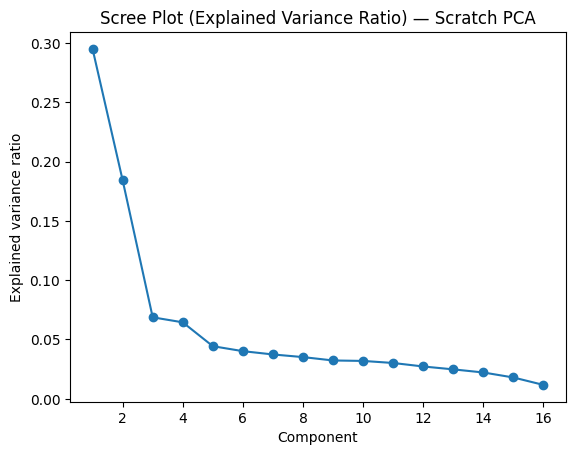

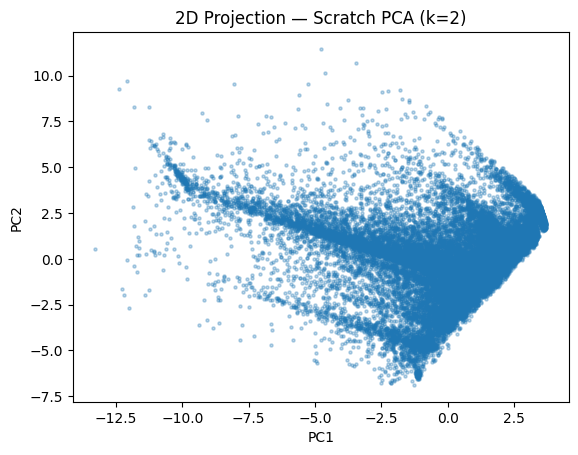

Scratch EVR (first 2): [0.29498051 0.18431077]
sklearn EVR (first 2): [0.29498051 0.18431077]


In [ ]:
def pca_from_scratch(X, k=None):
    Xc = X - X.mean(axis=0, keepdims=True)
    C = np.dot(Xc.T, Xc) / (Xc.shape[0] - 1)
    eigvals, eigvecs = np.linalg.eigh(C)   
    order = np.argsort(eigvals)[::-1]     
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    evr = eigvals / eigvals.sum()
    if k is None:
        k = X.shape[1]
    W = eigvecs[:, :k]        
    X_proj = np.dot(Xc, W)
    return W, evr, X_proj

scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(df_w[feature_cols].values.astype(float))

W, evr, X2 = pca_from_scratch(X_scaled, k=2)

plt.figure()
plt.plot(np.arange(1, min(16, len(evr))+1), evr[:16], marker="o")
plt.title("Scree Plot (Explained Variance Ratio) — Scratch PCA")
plt.xlabel("Component")
plt.ylabel("Explained variance ratio")
plt.show()

plt.figure()
plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.3)
plt.title("2D Projection — Scratch PCA (k=2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

skpca = SKPCA(n_components=2, random_state=42)
X2_sk = skpca.fit_transform(X_scaled)

print("Scratch EVR (first 2):", evr[:2])
print("sklearn EVR (first 2):", skpca.explained_variance_ratio_)


Linear Regression with Gradient Descent

Deliverables:
- Loss vs epochs (for different learning rates)
- Coefficient comparison vs sklearn

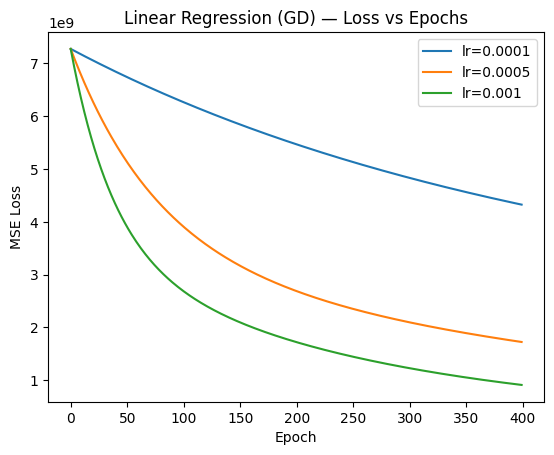

Best learning rate: 0.001
Scratch Linear Regression:
MSE: 929260058.2390494
MAE: 24244.046943580714
R2 : 0.8130262476457406

Sklearn LinearRegression:
MSE: 5.995774553791284e-20
MAE: 1.7254872849055877e-10
R2 : 1.0

Coefficient comparison (first 10 features):
Scratch theta (bias + first 9): [27620.70517418  2521.60167936  -361.17128229   577.0549459
   -62.57409198   357.06920112  1180.02158028  1641.39912361
   450.60760253   -82.55688277]
Sklearn coef  (first 10):       [ 5.01255164e+04 -1.81308284e-11  2.00088834e-11 -1.21826541e-11
 -1.92148212e-11  1.76017161e-11 -3.36928056e-13 -5.04928150e-11
 -2.39938477e-11 -1.52436302e-11]


In [29]:
y_reg = df_w["BILL_AMT1"].values.astype(float)

X_reg = df_w[feature_cols].values.astype(float)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
Xr_train_s = scaler_reg.fit_transform(Xr_train)
Xr_test_s  = scaler_reg.transform(Xr_test)

def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

Xr_train_b = add_bias(Xr_train_s)
Xr_test_b  = add_bias(Xr_test_s)

class LinearRegressionGD:
    def __init__(self, lr=0.01, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.theta = None
        self.loss_history = []

    def fit(self, Xb, y):
        n, d = Xb.shape
        self.theta = np.zeros(d)
        for _ in range(self.epochs):
            yhat = np.dot(Xb, self.theta)
            error = yhat - y
            loss = (error**2).mean()
            self.loss_history.append(loss)
            grad = (2 / n) * np.dot(Xb.T, error)
            self.theta -= self.lr * grad
        return self

    def predict(self, Xb):
        return Xb @ self.theta

lrs = [1e-4, 5e-4, 1e-3]
models = []
for lr in lrs:
    m = LinearRegressionGD(lr=lr, epochs=400).fit(Xr_train_b, yr_train)
    models.append(m)

plt.figure()
for lr, m in zip(lrs, models):
    plt.plot(m.loss_history, label=f"lr={lr}")
plt.title("Linear Regression (GD) — Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

best_idx = int(np.argmin([m.loss_history[-1] for m in models]))
best_lr = lrs[best_idx]
lin_gd = models[best_idx]
print("Best learning rate:", best_lr)

yr_pred = lin_gd.predict(Xr_test_b)
print("Scratch Linear Regression:")
print("MSE:", mean_squared_error(yr_test, yr_pred))
print("MAE:", mean_absolute_error(yr_test, yr_pred))
print("R2 :", r2_score(yr_test, yr_pred))

sk_lin = SKLinearRegression()
sk_lin.fit(Xr_train_s, yr_train)
yr_pred_sk = sk_lin.predict(Xr_test_s)

print("\nSklearn LinearRegression:")
print("MSE:", mean_squared_error(yr_test, yr_pred_sk))
print("MAE:", mean_absolute_error(yr_test, yr_pred_sk))
print("R2 :", r2_score(yr_test, yr_pred_sk))

print("\nCoefficient comparison (first 10 features):")
print("Scratch theta (bias + first 9):", lin_gd.theta[:10])
print("Sklearn coef  (first 10):      ", np.r_[sk_lin.intercept_, sk_lin.coef_[:9]])


## Logistic Regression from Scratch (Simple)
This targets the real label: `default.payment.next.month` (binary classification).
We implement logistic regression with gradient descent.

Deliverables:
- Confusion matrix
- Accuracy / Precision / Recall
- Compare to sklearn LogisticRegression

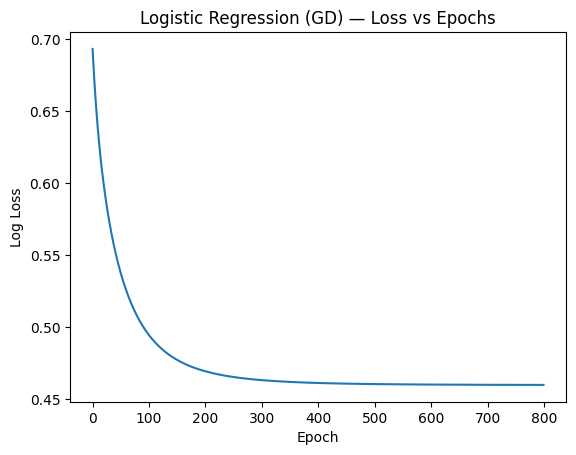

Scratch Logistic Regression:
Accuracy : 0.8095
Precision: 0.6862348178137652
Recall   : 0.2554634513941221
Confusion matrix:
 [[4518  155]
 [ 988  339]]

Sklearn LogisticRegression:
Accuracy : 0.81
Precision: 0.6829745596868885
Recall   : 0.2629992464204974
Confusion matrix:
 [[4511  162]
 [ 978  349]]


In [28]:
y_cls = df_w[target_col].values.astype(int)
X_cls = df_w[feature_cols].values.astype(float)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

scaler_cls = StandardScaler()
Xc_train_s = scaler_cls.fit_transform(Xc_train)
Xc_test_s  = scaler_cls.transform(Xc_test)

Xc_train_b = add_bias(Xc_train_s)
Xc_test_b  = add_bias(Xc_test_s)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegressionGD:
    def __init__(self, lr=0.05, epochs=800, reg_lambda=0.0):
        self.lr = lr
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.theta = None
        self.loss_history = []

    def fit(self, Xb, y):
        n, d = Xb.shape
        self.theta = np.zeros(d)
        for _ in range(self.epochs):
            z = np.dot(Xb, self.theta)
            p = sigmoid(z)
            eps = 1e-12
            loss = -(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)).mean()
            if self.reg_lambda > 0:
                loss += (self.reg_lambda / (2 * n)) * np.sum(self.theta[1:]**2)
            self.loss_history.append(loss)

            grad = (1 / n) * np.dot(Xb.T, (p - y))
            if self.reg_lambda > 0:
                reg = (self.reg_lambda / n) * self.theta
                reg[0] = 0.0
                grad += reg
            self.theta -= self.lr * grad
        return self

    def predict_proba(self, Xb):
        return sigmoid(Xb @ self.theta)

    def predict(self, Xb, threshold=0.5):
        return (self.predict_proba(Xb) >= threshold).astype(int)

log_gd = LogisticRegressionGD(lr=0.05, epochs=800, reg_lambda=0.1).fit(Xc_train_b, yc_train)

plt.figure()
plt.plot(log_gd.loss_history)
plt.title("Logistic Regression (GD) — Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()

yc_pred = log_gd.predict(Xc_test_b, threshold=0.5)

print("Scratch Logistic Regression:")
print("Accuracy :", accuracy_score(yc_test, yc_pred))
print("Precision:", precision_score(yc_test, yc_pred, zero_division=0))
print("Recall   :", recall_score(yc_test, yc_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(yc_test, yc_pred))

sk_log = SKLogisticRegression(max_iter=2000)
sk_log.fit(Xc_train_s, yc_train)
yc_pred_sk = sk_log.predict(Xc_test_s)

print("\nSklearn LogisticRegression:")
print("Accuracy :", accuracy_score(yc_test, yc_pred_sk))
print("Precision:", precision_score(yc_test, yc_pred_sk, zero_division=0))
print("Recall   :", recall_score(yc_test, yc_pred_sk, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(yc_test, yc_pred_sk))


## E) Statistical Evaluation (15%)
Guidelines ask for:
- Regression: MSE, MAE, R² ✅ (done above)
- Classification: Accuracy, Precision, Recall ✅ (done above)
- **t-test comparing model to baseline**
- **Bootstrap confidence interval for accuracy**

We’ll do:
1) Baseline classifier: predict the majority class from training.
2) 5-fold CV on a **subset** for speed.
3) Paired t-test on fold accuracies.
4) Bootstrap 95% CI on test accuracy.

In [26]:
# --- 1) Baseline (majority class) on the test set ---
majority_class = int(pd.Series(yc_train).mode()[0])
baseline_pred = np.full_like(yc_test, majority_class)
acc_baseline_test = accuracy_score(yc_test, baseline_pred)
acc_model_test = accuracy_score(yc_test, yc_pred)

print("Test Accuracy — Baseline:", acc_baseline_test)
print("Test Accuracy — Scratch Logistic:", acc_model_test)

# --- 2) 5-fold CV (subset for speed) ---
def kfold_indices(n, k=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds

# Use a smaller subset for quick CV
n_sub = 6000
sub_idx = np.random.default_rng(42).choice(len(X_cls), size=n_sub, replace=False)
X_sub = X_cls[sub_idx]
y_sub = y_cls[sub_idx]

# scale inside each fold (important)
folds = kfold_indices(n_sub, k=5, seed=42)

acc_model_folds = []
acc_base_folds = []

for i in range(5):
    test_idx = folds[i]
    train_idx = np.hstack([folds[j] for j in range(5) if j != i])

    Xtr, ytr = X_sub[train_idx], y_sub[train_idx]
    Xte, yte = X_sub[test_idx], y_sub[test_idx]

    sc = StandardScaler()
    Xtr_s = sc.fit_transform(Xtr)
    Xte_s = sc.transform(Xte)

    Xtr_b = add_bias(Xtr_s)
    Xte_b = add_bias(Xte_s)

    # Baseline majority on this fold
    maj = int(pd.Series(ytr).mode()[0])
    y_base = np.full_like(yte, maj)
    acc_base_folds.append(accuracy_score(yte, y_base))

    # Train scratch logistic quickly (fewer epochs for CV)
    m = LogisticRegressionGD(lr=0.05, epochs=400, reg_lambda=0.1).fit(Xtr_b, ytr)
    yhat = m.predict(Xte_b)
    acc_model_folds.append(accuracy_score(yte, yhat))

acc_model_folds = np.array(acc_model_folds)
acc_base_folds = np.array(acc_base_folds)

print("Fold Accuracies (model):   ", acc_model_folds)
print("Fold Accuracies (baseline):", acc_base_folds)
print("Mean model acc:", acc_model_folds.mean(), " | Mean baseline acc:", acc_base_folds.mean())

# --- 3) Paired t-test (if SciPy exists) ---
try:
    from scipy import stats
    t_stat, p_val = stats.ttest_rel(acc_model_folds, acc_base_folds)
    print("Paired t-test: t =", t_stat, ", p =", p_val)
except Exception as e:
    print("SciPy not available for t-test. Error:", e)
    # simple fallback: just print the differences
    diffs = acc_model_folds - acc_base_folds
    print("Differences per fold:", diffs, " | mean diff:", diffs.mean())

# --- 4) Bootstrap 95% CI for test accuracy ---
rng = np.random.default_rng(42)
B = 2000
acc_samples = []
n_test = len(yc_test)
for _ in range(B):
    bs_idx = rng.integers(0, n_test, size=n_test)
    acc_samples.append(accuracy_score(yc_test[bs_idx], yc_pred[bs_idx]))
acc_samples = np.array(acc_samples)
ci_low, ci_high = np.percentile(acc_samples, [2.5, 97.5])
print(f"Bootstrap 95% CI for Scratch Logistic test accuracy: [{ci_low:.4f}, {ci_high:.4f}]")


Test Accuracy — Baseline: 0.7788333333333334
Test Accuracy — Scratch Logistic: 0.8095
Fold Accuracies (model):    [0.81666667 0.82333333 0.81416667 0.81333333 0.79083333]
Fold Accuracies (baseline): [0.78666667 0.78416667 0.77666667 0.7925     0.755     ]
Mean model acc: 0.8116666666666668  | Mean baseline acc: 0.779
Paired t-test: t = 9.787772921002883 , p = 0.0006106357081655115
Bootstrap 95% CI for Scratch Logistic test accuracy: [0.7997, 0.8190]


## Summary Table (Quick)
This is a small summary you can copy to your report.

In [27]:
summary = pd.DataFrame({
    "Task": ["Regression (BILL_AMT1)", "Classification (Default)"],
    "Model": ["Linear Regression (GD scratch)", "Logistic Regression (GD scratch)"],
    "Main Metrics": [
        f"MSE={mean_squared_error(yr_test, yr_pred):.2f}, MAE={mean_absolute_error(yr_test, yr_pred):.2f}, R2={r2_score(yr_test, yr_pred):.4f}",
        f"Acc={accuracy_score(yc_test, yc_pred):.4f}, Prec={precision_score(yc_test, yc_pred, zero_division=0):.4f}, Rec={recall_score(yc_test, yc_pred, zero_division=0):.4f}"
    ]
})
display(summary)


,Task,Model,Main Metrics
0,Regression (BILL_AMT1),Linear Regression (GD scratch),"MSE=929260058.24, MAE=24244.05, R2=0.8130"
1,Classification (Default),Logistic Regression (GD scratch),"Acc=0.8095, Prec=0.6862, Rec=0.2555"
